# Problem Statement:
HELP International is an international humanitarian NGO that is committed to fighting poverty and providing the people of backward countries with basic amenities and relief during the time of disasters and natural calamities. It runs a lot of operational projects from time to time along with advocacy drives to raise awareness as well as for funding purposes.

After the recent funding programmes, they have been able to raise around $ 10 million. Now the CEO of the NGO needs to decide how to use this money strategically and effectively. The significant issues that come while making this decision are mostly related to choosing the countries that are in the direst need of aid. The requirements of the company are:

1. To categorise the countries using some socio-economic and health factors that determine the overall development of the country.
2. To shortlist some of the countries which the CEO needs to focus on the most. 

# Country Development Data Analysis

The steps involved in this analysis are mentioned as follows:
1. Reading and understanding the data
2. Cleaning the data
3. Structuring the data for modelling
4. Principal Component Analysis (PCA)
5. Checking for Hopkins Statistic
6. Clustering
7. Profiling of the clusters
8. Final analysis of the data
9. Recommendations

## Reading and understanding the data

### Importing the data

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import scale
from sklearn.cluster import KMeans

In [3]:
path = input("Enter the path to data file: ") #Enter the path to the file to be used by replacing all the '\' using '\\' or '/'

Enter the path to data file: D:\\upGrad\\.CONTENT\\Assignments\\Clustering and PCA Assignment


In [5]:
data = pd.read_csv(path+'/country-data.csv') #the path will be used to read the file
data.head() #checking if data from application_data file is loading properly

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


### Checking the structure of the data

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
country       167 non-null object
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null int64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null int64
dtypes: float64(7), int64(2), object(1)
memory usage: 13.1+ KB


In [5]:
data.shape

(167, 10)

In [6]:
data.columns

Index(['country', 'child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp'],
      dtype='object')

In [7]:
data.dtypes

country        object
child_mort    float64
exports       float64
health        float64
imports       float64
income          int64
inflation     float64
life_expec    float64
total_fer     float64
gdpp            int64
dtype: object

Here, we can see that the data 167 rows and 10 columns.
The column names are - 'country', 'child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp'
In the above data, the clustering will be done based on the column named 'country'.

## Cleaning the data

### Checking and treating missing values

In [8]:
round(100*(data.isnull().sum())/len(data), 2)

country       0.0
child_mort    0.0
exports       0.0
health        0.0
imports       0.0
income        0.0
inflation     0.0
life_expec    0.0
total_fer     0.0
gdpp          0.0
dtype: float64

We can see that there are no missing values present in any of the columns. So, no action is required.

In [9]:
data = data.drop_duplicates() #dropping duplicate rows
data.shape

(167, 10)

All the columns in the data seem to be in the correct format. So, no further changes are made.

## Structuring the data for modelling

### Checking and treating outliers

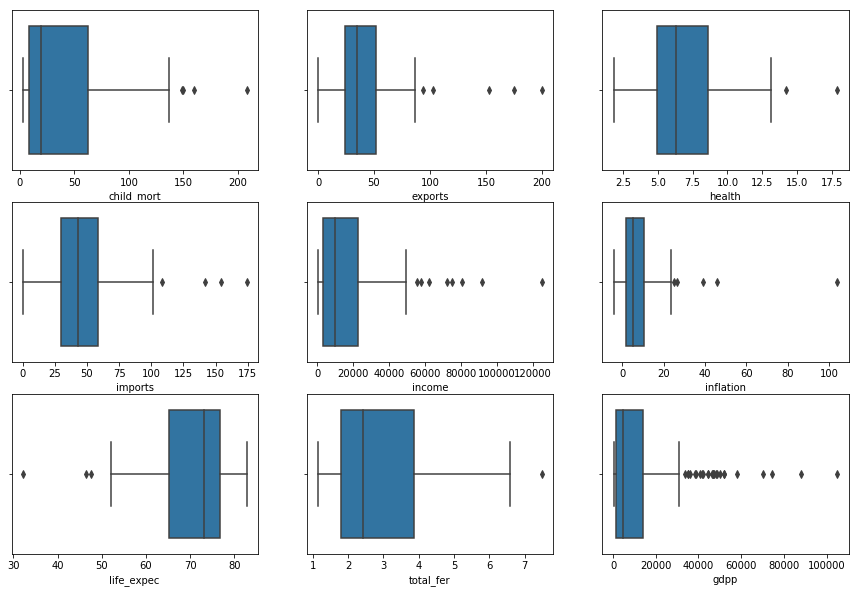

In [6]:
#visualising data to check for outliers
temp = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']
plt.figure(figsize = (15,10))
for i in enumerate(temp):
    plt.subplot(3,3,i[0]+1)
    sns.boxplot(x = i[1], data = data)

The above analysis shows that there are very few outliers in columns 'child_mort', 'exports', 'health', 'imports', 'inflation', 'income', 'life_expec' and 'total_fer'. Also, the number of outliers in the column name 'gdpp' is comparatively high.
However, we will keep the outliers in the column 'gdpp' since they might form a unique cluster.

In case of the columns with low number of outliers, removing the outliers might cause in loss of data which can result in the NGO not offering aid to the countries that genuinely need it. Hence, we will cap the columns named 'child_mort', 'exports', 'health', 'imports', 'inflation', 'income', 'life_expec', 'total_fer'.

In [7]:
#outlier treatment
temp2 = ['child_mort', 'exports', 'health', 'imports', 'inflation', 'income', 'life_expec', 'total_fer']

for col in temp2:
    percentiles = data[col].quantile([0.01,0.99]).values
    data[col] = np.clip(data[col], percentiles[0], percentiles[1])
data.shape

(167, 10)

Here, we can see that no data point is lost during the outlier treatment process.

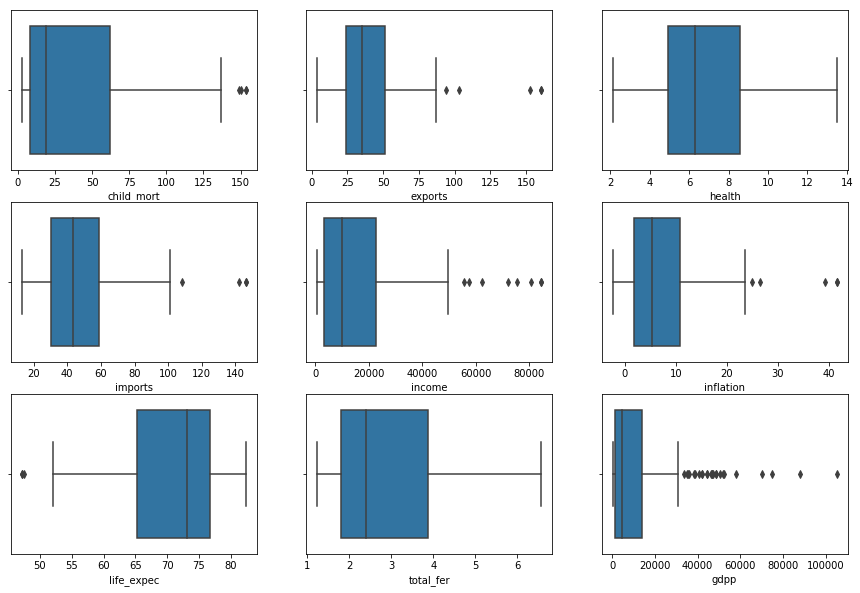

In [8]:
#visualising the data again for the outliers
plt.figure(figsize = (15,10))
for i in enumerate(temp):
    plt.subplot(3,3,i[0]+1)
    sns.boxplot(x = i[1], data = data)

In [9]:
#separating the column name 'country' from the dataset for analysis since this column is only an identifier

country_name = data['country']
new_data = data.drop("country", axis=1)
new_data.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,10.0,7.58,44.9,1610.0,9.44,56.2,5.82,553
1,16.6,28.0,6.55,48.6,9930.0,4.49,76.3,1.65,4090
2,27.3,38.4,4.17,31.4,12900.0,16.10,76.5,2.89,4460
3,119.0,62.3,2.85,42.9,5900.0,22.40,60.1,6.16,3530
4,10.3,45.5,6.03,58.9,19100.0,1.44,76.8,2.13,12200


In [10]:
new_data.columns

Index(['child_mort', 'exports', 'health', 'imports', 'income', 'inflation',
       'life_expec', 'total_fer', 'gdpp'],
      dtype='object')

### Scaling the data

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() #initialisation

scaled_data = scaler.fit_transform(new_data)
print(scaled_data.max())
print(scaled_data[:10,:3])

5.036506694375584
[[ 1.34401227 -1.20288346  0.30076193]
 [-0.54754345 -0.50031879 -0.09019012]
 [-0.27254826 -0.09439253 -0.99355506]
 [ 2.08418625  0.83845723 -1.49458099]
 [-0.70945651  0.1827302  -0.28756397]
 [-0.60151447 -0.85550426  0.49813578]
 [-0.50899273 -0.78134466 -0.90625508]
 [-0.85080918 -0.82037603  0.73726179]
 [-0.86365943  0.40911215  1.59887457]
 [ 0.03328751  0.52620626 -0.34449874]]


Here, we can see the data has been scaled and the maximum value present in the scaled_data numpy array is 5.1924992205174405

##  Principal Component Analysis (PCA)

In [12]:
from sklearn.decomposition import PCA

pca = PCA(random_state=42) #initialising PCA with random state = 42

In [13]:
pca.fit(scaled_data)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)

In [14]:
pca.components_

array([[-4.16823286e-01,  2.75422819e-01,  1.58320905e-01,
         1.54639760e-01,  4.02235966e-01, -2.10723007e-01,
         4.25937095e-01, -4.03957308e-01,  3.88097643e-01],
       [ 1.75575198e-01,  6.16654675e-01, -2.23616639e-01,
         6.83981401e-01,  7.04967067e-03, -1.09894978e-02,
        -2.14998698e-01,  1.47455102e-01, -5.41986097e-02],
       [-8.03420439e-02,  1.73948327e-01, -6.41930730e-01,
        -2.87189403e-01,  2.54426081e-01,  6.18497242e-01,
         1.25617924e-01, -3.07373320e-02,  6.88346236e-02],
       [ 3.73566409e-01,  3.57134727e-02,  3.44252282e-01,
        -1.20835564e-01,  4.30692120e-01,  1.58915317e-01,
        -1.87037027e-01,  4.11833932e-01,  5.57424436e-01],
       [-1.74119185e-01,  5.43142130e-02,  5.65663342e-01,
         2.26045031e-01, -1.74453847e-01,  7.24186272e-01,
         6.93597404e-02, -1.05097178e-01, -1.57876571e-01],
       [ 1.43539425e-01, -3.80661878e-02,  1.78795341e-02,
        -5.10971447e-02,  1.70541350e-01,  4.967293

In [15]:
pca.explained_variance_ratio_

array([0.47124156, 0.16832886, 0.13450941, 0.10714038, 0.06803896,
       0.02044181, 0.01402147, 0.00963902, 0.00663853])

<BarContainer object of 9 artists>

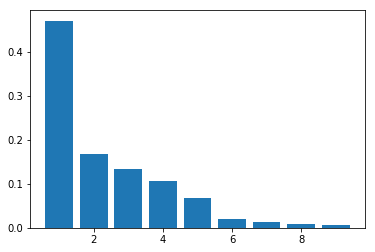

In [16]:
#plotting the percentage variance in graph
plt.bar(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)

Here, we can see that the first 4 variables explain around 90% of the total variance of the dataset while the first 5 variables explain around 96% of the variance. Similarly, we can also see that the last 2 variables explain approximately 1% of the variance in the dataset combined.

##### Making a scree plot

In [17]:
cumulative_var = np.cumsum(pca.explained_variance_ratio_)

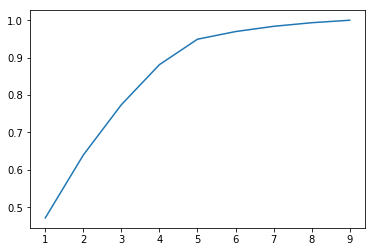

In [18]:
plt.plot(range(1,len(cumulative_var)+1), cumulative_var) #plotting cumulative variance in dataset against number of components

The scree plot also shows that the cumulative variance is approximately 90% when the number of components is 4. On the other hand, cumulative variance becomes 80% when the number of components is 3.
We will be performing PCA again with 3 components.

In [19]:
pca2 = PCA(n_components=3, random_state=42)
newdata = pca2.fit_transform(scaled_data)
newdata.shape

(167, 3)

In [20]:
df = pd.DataFrame(newdata, columns=["PC1", "PC2","PC3"])
df.head()

,PC1,PC2,PC3
0,-3.018022,0.047808,-0.859444
1,0.455670,-0.572258,-0.262216
2,-0.372576,-0.482506,1.528972
3,-3.152088,1.688250,1.770879
4,1.105680,0.189868,-0.217522


In [21]:
pca_df = pd.concat([df, country_name], axis=1)
pca_df.head()

,PC1,PC2,PC3,country
0,-3.018022,0.047808,-0.859444,Afghanistan
1,0.455670,-0.572258,-0.262216,Albania
2,-0.372576,-0.482506,1.528972,Algeria
3,-3.152088,1.688250,1.770879,Angola
4,1.105680,0.189868,-0.217522,Antigua and Barbuda


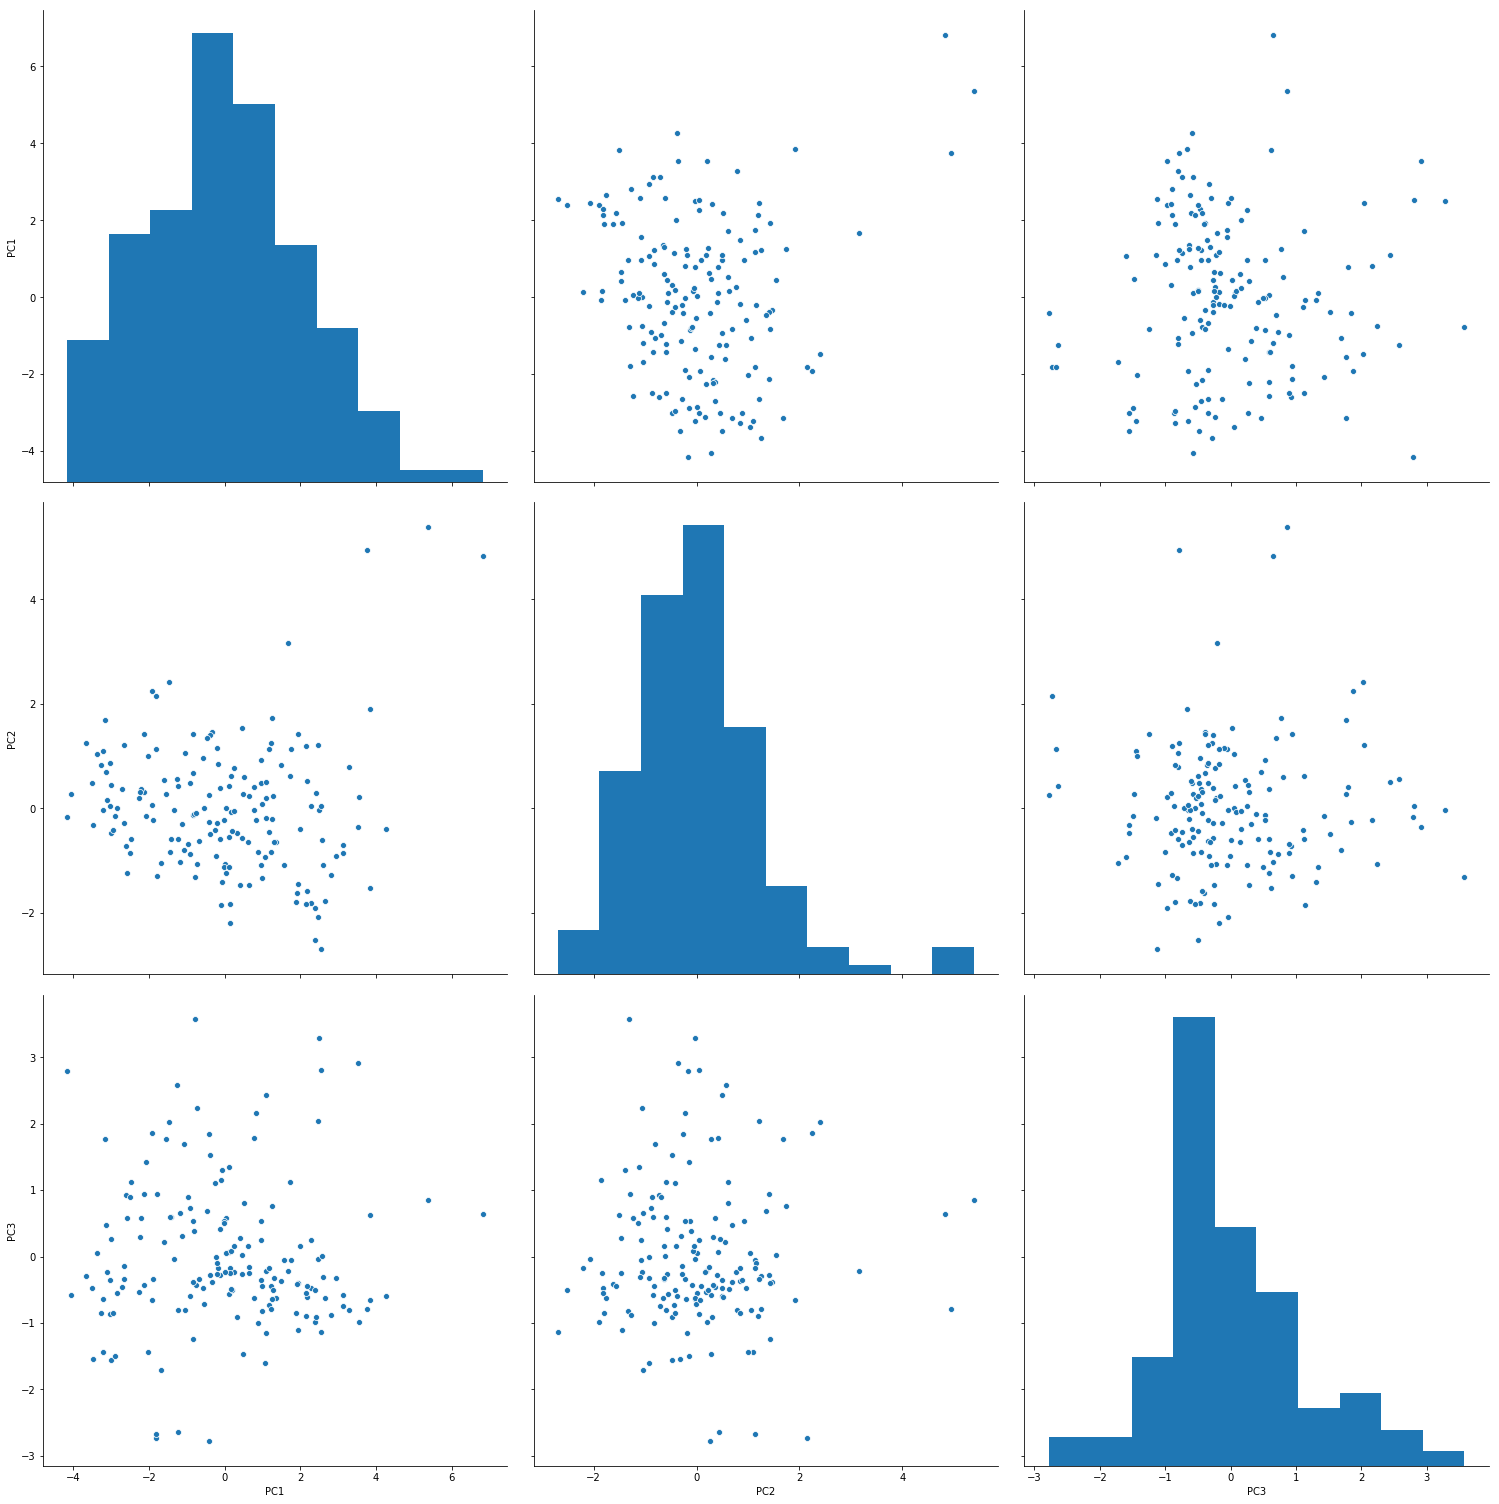

In [22]:
sns.pairplot(data=pca_df, size=7)

As per the pairplots above, the variables do not seem to be correlated as there are no obvious patterns.

## Checking for Hopkins Statistic

In [23]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [24]:
#passing the pca dataframe in the Hopkins Statistic function without the 'country' column
hopkins(pca_df.drop('country',axis=1))

0.8103508580097446

The Hopkins Statistic for the given dataset seems to range between 0.70 and 0.86 which is fairly high (reaching towards 1). This indicates that the data points present in this dataset can form clusters.

## Clustering

### K-means Clustering

#### Determining optimal number of clusters

In [25]:
#using the scaled dataframe without country names for clustering
df.head()

,PC1,PC2,PC3
0,-3.018022,0.047808,-0.859444
1,0.455670,-0.572258,-0.262216
2,-0.372576,-0.482506,1.528972
3,-3.152088,1.688250,1.770879
4,1.105680,0.189868,-0.217522


##### Making an elbow-curve plot

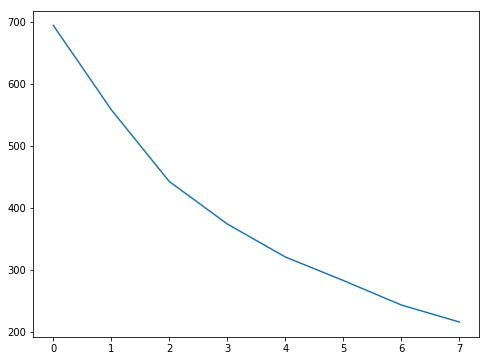

In [26]:
# plotting the elbow-curve or squared sum distances (SSD)
elbow = []
cluster_range = range(2,10)
for i in cluster_range:
    kmeans = KMeans(n_clusters=i, max_iter=60).fit(df)
    
    elbow.append(kmeans.inertia_)

plt.figure(figsize = (8,6))
plt.plot(elbow)

As per the elbow-curve plot above, there is an elbow at n = 2. This point on the graph represents the number of clusters (K) = 4. Hence, we will be taking the number of clusters to be 4. 

##### Performing silhouette score analysis

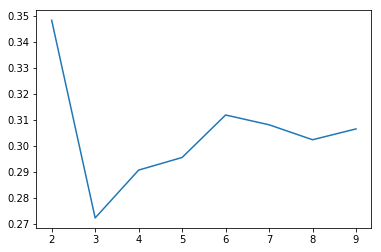

In [27]:
from sklearn.metrics import silhouette_score

#silhouette score plot
silh = []
for j in cluster_range:
    kmeans = KMeans(n_clusters=j, max_iter=60).fit(df)    
    cluster_labels = kmeans.labels_
    
    silhouette_avg = silhouette_score(df, cluster_labels)
    silh.append([j, silhouette_avg])
    
plt.plot(pd.DataFrame(silh)[0],pd.DataFrame(silh)[1])

Looking at the silhouette score plot above, we can see that the silhouette score for the number of clusters (K) = 3 is the lowest. However, since the number principal components is 3, it would not be a good idea to keep 3 clusters. The silhouette score for K=4 is the second lowest and doesn't differ much from that of K=3.

Upon checking both the elbow-curve plot and the silhouette score plot, we will select the number of clusters to be 4.

#### Final model using selected K

In [28]:
# number of clusters (K) = 4
km_model = KMeans(n_clusters = 4, max_iter=60)
km_model.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=60,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [29]:
km_model.labels_

array([0, 3, 3, 0, 1, 3, 3, 1, 1, 3, 1, 1, 3, 1, 3, 1, 3, 0, 3, 3, 1, 3,
       3, 1, 1, 0, 0, 3, 0, 1, 3, 0, 0, 1, 3, 3, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 3, 3, 3, 3, 3, 0, 1, 3, 1, 1, 3, 0, 3, 1, 0, 1, 3, 3, 0, 0, 3,
       0, 1, 1, 3, 3, 3, 3, 2, 1, 1, 3, 1, 3, 3, 0, 0, 1, 3, 0, 1, 1, 0,
       0, 3, 1, 2, 1, 0, 0, 3, 1, 0, 2, 0, 1, 0, 1, 3, 1, 3, 0, 3, 0, 3,
       1, 1, 0, 0, 1, 3, 0, 1, 3, 3, 3, 1, 1, 1, 3, 3, 0, 3, 3, 0, 1, 2,
       0, 2, 1, 1, 0, 0, 1, 1, 3, 3, 0, 3, 1, 1, 3, 0, 3, 0, 0, 3, 3, 3,
       3, 0, 3, 1, 1, 1, 1, 3, 3, 3, 3, 0, 0])

In [30]:
#adding an additional column with the cluster ids to the dataframe
km_labels = pd.Series(km_model.labels_)
clustered_data = pd.concat([pca_df.reset_index().drop('index', axis =1), km_labels.reset_index().drop('index', axis =1)], axis=1)
clustered_data.columns = ['PC1', 'PC2', 'PC3', 'country','cluster_id']
clustered_data.head()

,PC1,PC2,PC3,country,cluster_id
0,-3.018022,0.047808,-0.859444,Afghanistan,0
1,0.455670,-0.572258,-0.262216,Albania,3
2,-0.372576,-0.482506,1.528972,Algeria,3
3,-3.152088,1.688250,1.770879,Angola,0
4,1.105680,0.189868,-0.217522,Antigua and Barbuda,1


In [31]:
#counting the number of countries in each cluster based on k-means clustering
clustered_data.cluster_id.value_counts()

3    63
1    54
0    45
2     5
Name: cluster_id, dtype: int64

### Hierarchical Clustering

In [32]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
df.head()

,PC1,PC2,PC3
0,-3.018022,0.047808,-0.859444
1,0.455670,-0.572258,-0.262216
2,-0.372576,-0.482506,1.528972
3,-3.152088,1.688250,1.770879
4,1.105680,0.189868,-0.217522


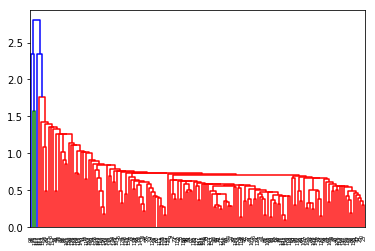

In [33]:
# single linkage
mergings = linkage(df, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

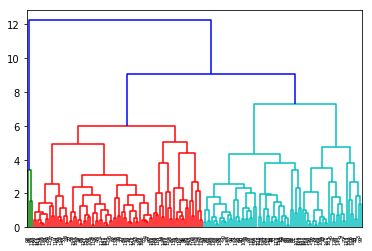

In [34]:
# complete linkage
mergings = linkage(df, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [35]:
# hierarchical clustering for 4 clusters
cluster_labels = cut_tree(mergings, n_clusters=4).reshape(-1, )
cluster_labels

array([0, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 0, 0, 0, 2, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 2, 1, 0, 1, 1, 1,
       1, 1, 1, 2, 1, 2, 2, 1, 0, 1, 1, 2, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 0, 2, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 3, 1, 0, 0, 1, 1, 0, 3, 2, 1, 0, 1, 2, 1, 1, 0, 2, 0, 2,
       1, 1, 0, 2, 1, 1, 2, 1, 0, 1, 2, 1, 1, 1, 1, 2, 0, 1, 1, 0, 1, 1,
       0, 3, 1, 1, 0, 0, 1, 1, 2, 1, 2, 1, 1, 1, 0, 0, 1, 2, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 2, 0, 2, 1, 2, 0])

In [36]:
# assigning cluster labels
clustered_data['cluster_labels'] = cluster_labels
clustered_data.head()

,PC1,PC2,PC3,country,cluster_id,cluster_labels
0,-3.018022,0.047808,-0.859444,Afghanistan,0,0
1,0.455670,-0.572258,-0.262216,Albania,3,1
2,-0.372576,-0.482506,1.528972,Algeria,3,2
3,-3.152088,1.688250,1.770879,Angola,0,2
4,1.105680,0.189868,-0.217522,Antigua and Barbuda,1,1


In [37]:
#counting the number of countries in each cluster based on cluster_labels from hierarchical clustering
clustered_data.cluster_labels.value_counts()

1    85
0    49
2    30
3     3
Name: cluster_labels, dtype: int64

### Cluster visualisation of the principal components

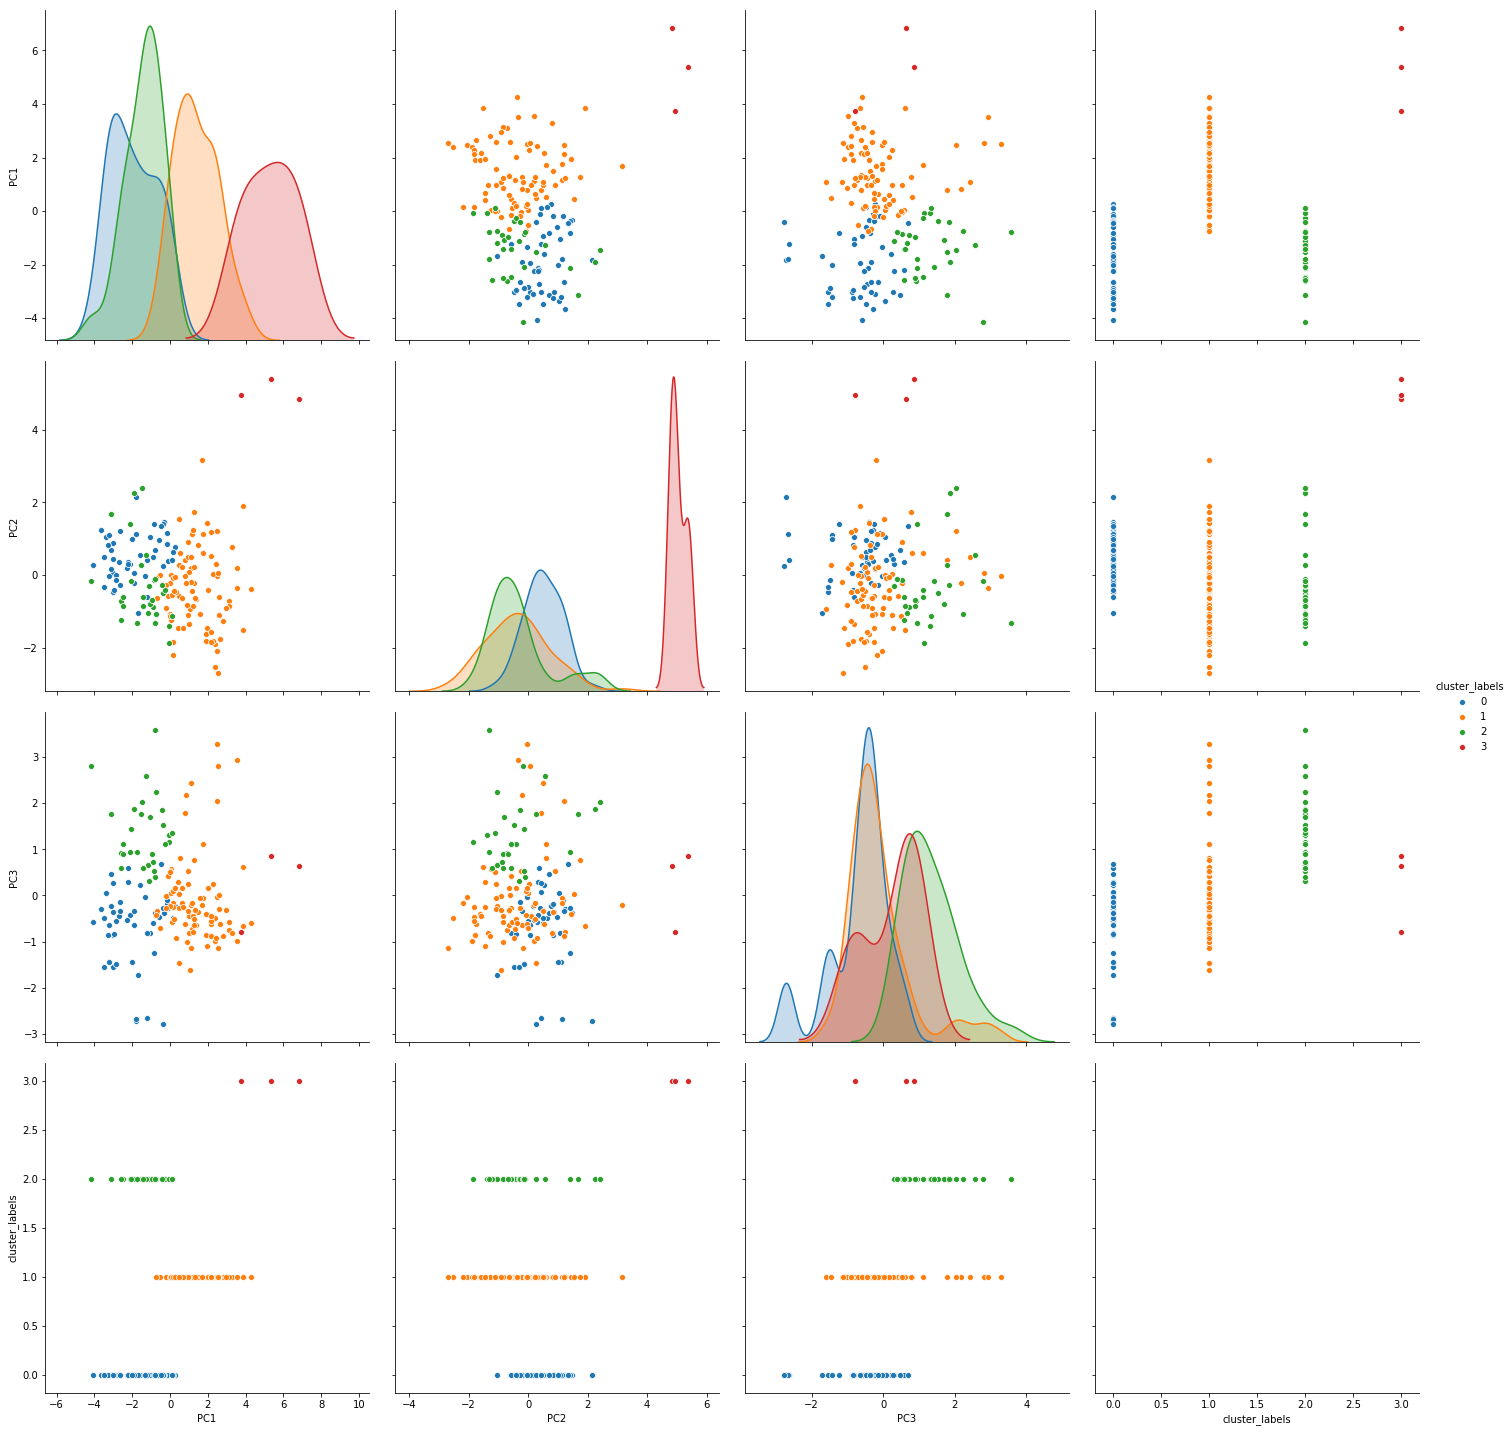

In [38]:
#visualisation based on hierarchical clustering
sns.pairplot(data=clustered_data.drop("cluster_id", axis=1), hue="cluster_labels",size=5)

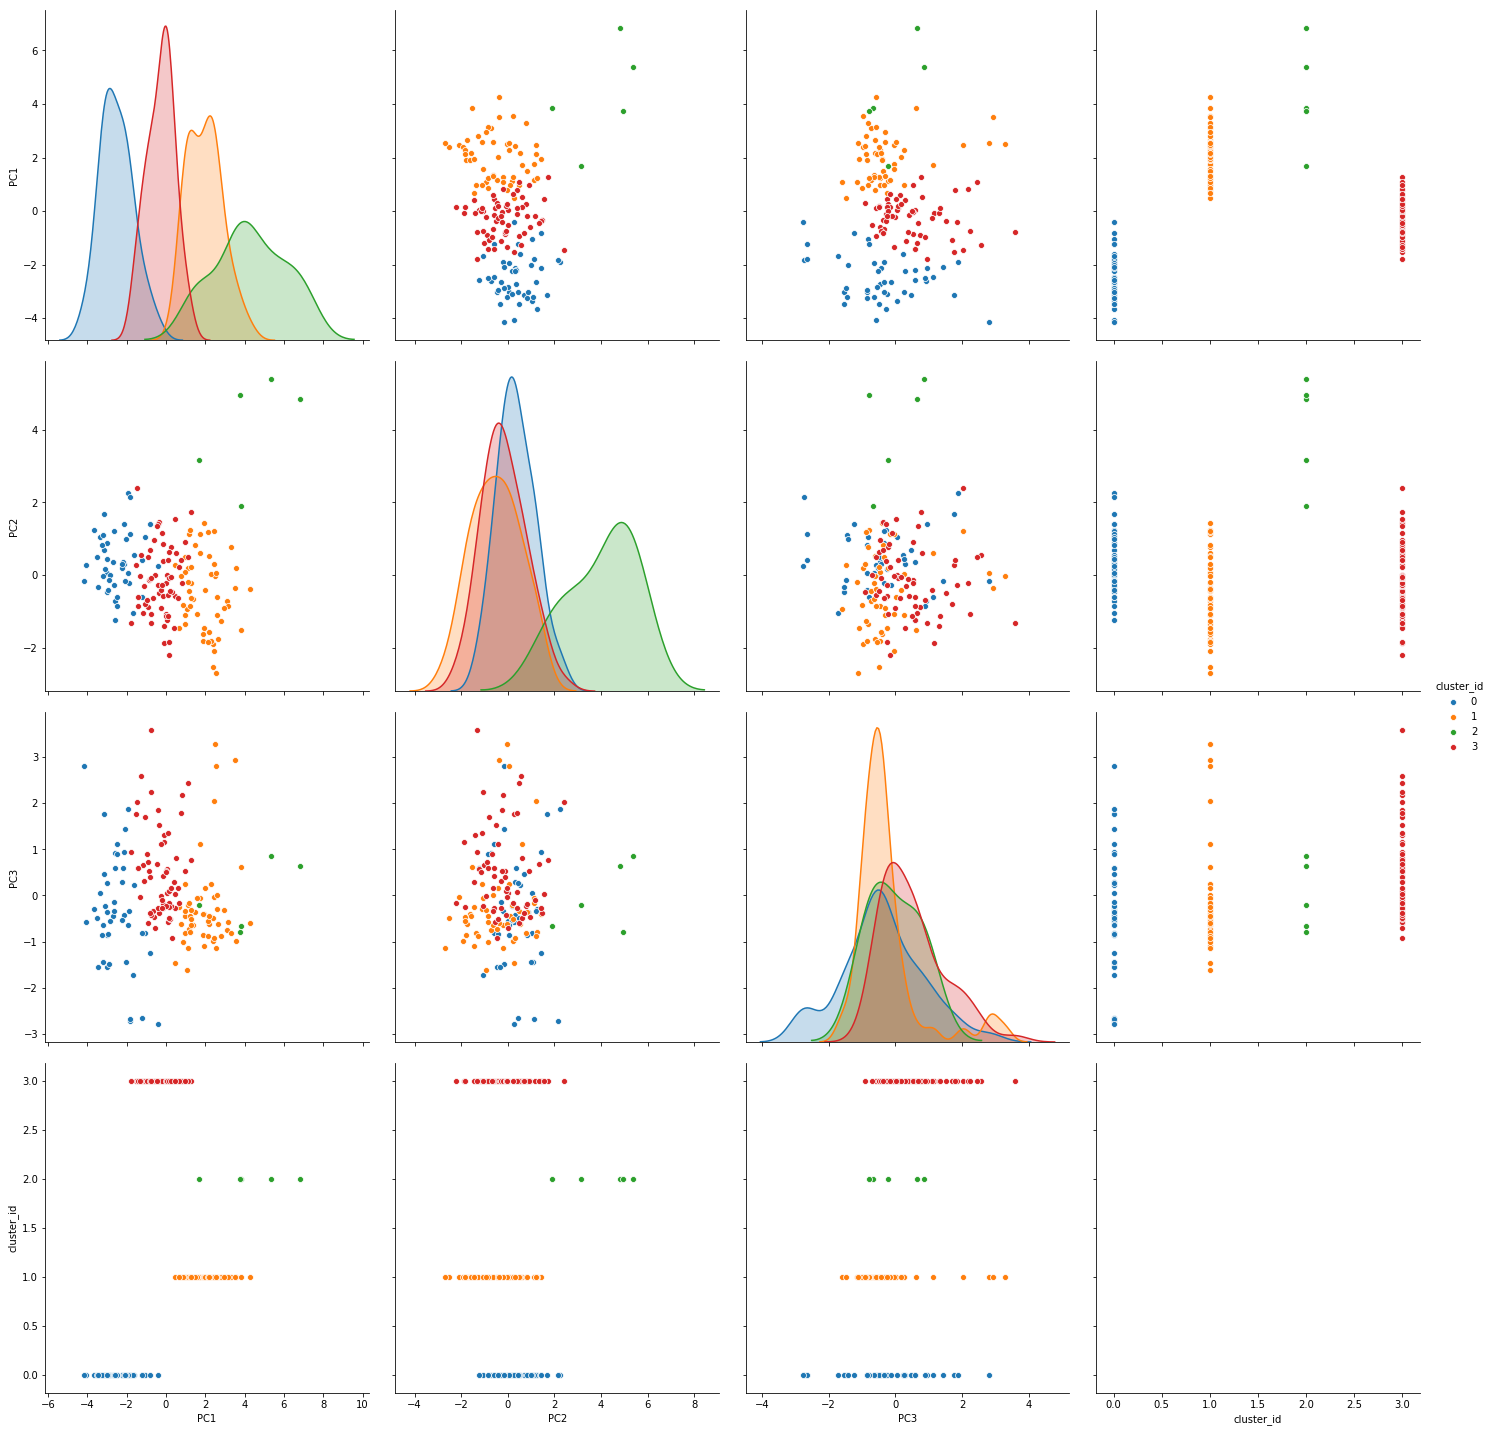

In [39]:
#visualisation based on k-means clustering
sns.pairplot(data=clustered_data.drop("cluster_labels", axis=1), hue="cluster_id",size=5)

## Profiling of the clusters

In [60]:
#the dataset with clusters IDs can be merged with the required columns from the original dataset
final_data = pd.merge(data[['gdpp', 'child_mort', 'income','country']],
                        clustered_data[['country','cluster_id','cluster_labels']], on = 'country')

In [61]:
final_data.head()

,gdpp,child_mort,income,country,cluster_id,cluster_labels
0,553,90.2,1610.0,Afghanistan,0,0
1,4090,16.6,9930.0,Albania,3,1
2,4460,27.3,12900.0,Algeria,3,2
3,3530,119.0,5900.0,Angola,0,2
4,12200,10.3,19100.0,Antigua and Barbuda,1,1


## Final analysis of the data

### Using K-means clustering

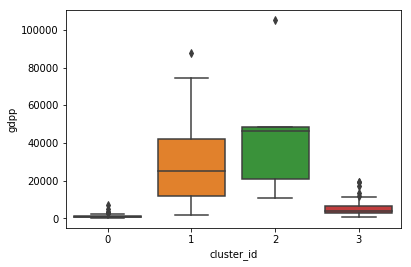

In [42]:
# plotting the 'gdpp', 'child_mort', and 'income' columns based on cluster_id
sns.boxplot(x='cluster_id', y='gdpp', data=final_data)

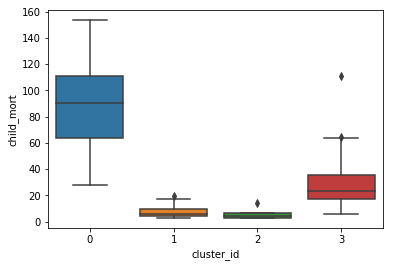

In [43]:
sns.boxplot(x='cluster_id', y='child_mort', data=final_data)

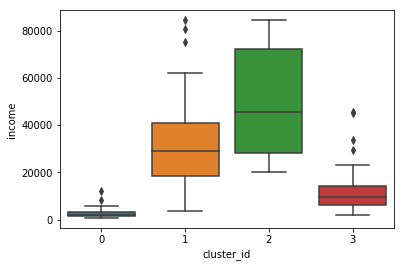

In [44]:
sns.boxplot(x='cluster_id', y='income', data=final_data)

In [45]:
#average gdpp, income, and child_mort of each of the clusters
grouped_data = final_data.drop("cluster_labels", axis=1).groupby("cluster_id").mean()
grouped_data

,gdpp,child_mort,income
cluster_id,,,
0,1284.488889,91.377778,2566.410667
1,28452.777778,7.133333,31926.000000
2,46440.000000,6.200000,50174.800000
3,5374.000000,28.601587,11508.253968


### Using hierarchical clustering

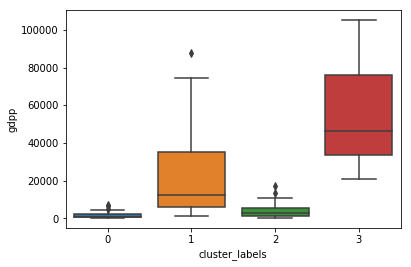

In [46]:
# plotting the 'gdpp', 'child_mort', and 'income' columns based on cluster_labels
sns.boxplot(x='cluster_labels', y='gdpp', data=final_data)

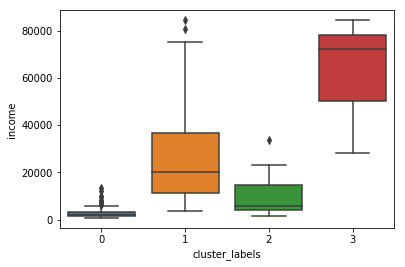

In [47]:
sns.boxplot(x='cluster_labels', y='income', data=final_data)

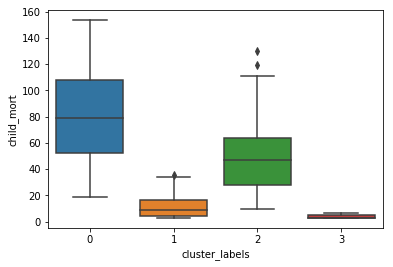

In [48]:
sns.boxplot(x='cluster_labels', y='child_mort', data=final_data)

In [74]:
#average gdpp, income, and child_mort of each of the clusters
grouped_data2 = final_data.drop("cluster_id", axis=1).groupby("cluster_labels").mean()
grouped_data2

,gdpp,child_mort,income
cluster_labels,,,
0,1626.204082,78.036735,3351.397551
1,20986.117647,11.130588,25677.223529
2,4293.666667,51.593333,9461.000000
3,57566.666667,4.133333,61591.333333


Checking the means and the visualisation of both K-means and hierarchical clustering, we can see that both the method have similar outputs.
Both the methods have formed 4 clusters in which one consists of the outliers or extremely well-performing countries and another has high gdpp and income with low child mortality which represents developed countries. A third cluster in both the clustering methods have average income and gdpp along with medium child mortality that depicts developing countries while the fourth cluster is formed with countries that are in dire need of aid since they have minimal income and gdpp while their child mortality is extremely high.
Additionally, the mean values of the 4 clusters in the terms of child mortality, income and gdpp is similar for both the hierarchical and K-means clustering. Hence, we can select either of the clustering methods. Here, we are going to use K-means clustering.

##### Observations made on the problem cluster or the cluster needing aid

1. It has the shortest distribution of gdpp with median almost touching 0
2. Its income distribution lies within the 25th percentile of the cluster which depicts developing countries
3. The child_mort distribution of this cluster is the most widespread with median value lying higher than the whisker values of all other clusters

#### Renaming the clusters

In [62]:
#assuming that cluster_id=0 is the problematic cluster
#this step will change every time the algorithm is run

def type_of_country(x):
    if x['cluster_id'] == 0:
        return 'Needs aid'
    elif x['cluster_id'] == 1:
        return 'Developed'
    elif x['cluster_id'] == 2:
        return 'Highly developed'
    else:
        return 'Developing'
    
final_data['country_type'] = final_data.apply(lambda x: type_of_country(x), axis=1)
final_data = final_data.drop(["cluster_id","cluster_labels"], axis=1)
final_data.head()

,gdpp,child_mort,income,country,country_type
0,553,90.2,1610.0,Afghanistan,Needs aid
1,4090,16.6,9930.0,Albania,Developing
2,4460,27.3,12900.0,Algeria,Developing
3,3530,119.0,5900.0,Angola,Needs aid
4,12200,10.3,19100.0,Antigua and Barbuda,Developed


In [63]:
#printing out the countries that need aid
final_data[final_data["country_type"]=='Needs aid']["country"]

0                   Afghanistan
3                        Angola
17                        Benin
25                 Burkina Faso
26                      Burundi
28                     Cameroon
31     Central African Republic
32                         Chad
36                      Comoros
37             Congo, Dem. Rep.
38                  Congo, Rep.
40                Cote d'Ivoire
50                      Eritrea
56                       Gambia
59                        Ghana
63                       Guinea
64                Guinea-Bissau
66                        Haiti
80                        Kenya
81                     Kiribati
84                          Lao
87                      Lesotho
88                      Liberia
93                   Madagascar
94                       Malawi
97                         Mali
99                   Mauritania
101       Micronesia, Fed. Sts.
106                  Mozambique
108                     Namibia
112                       Niger
113     

### Visualisation of the final dataset

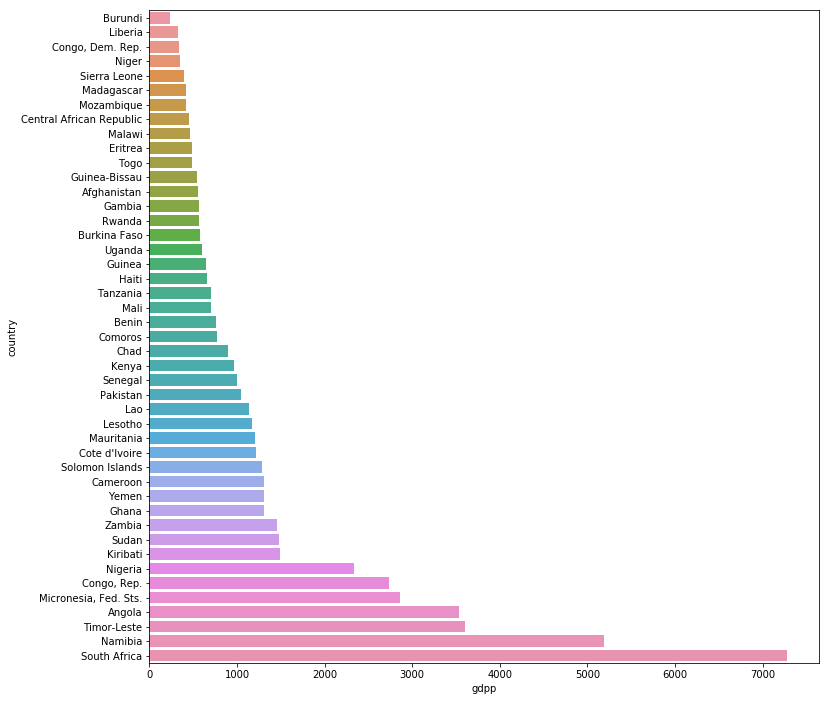

In [64]:
#visualisations using the countries that need aid
plt.figure(figsize = (12,12))
temp_df = final_data.sort_values(by=["gdpp"], ascending = True)
sns.barplot(x="gdpp", y = temp_df["country"].loc[temp_df["country_type"]=='Needs aid'], data = temp_df)
plt.show()

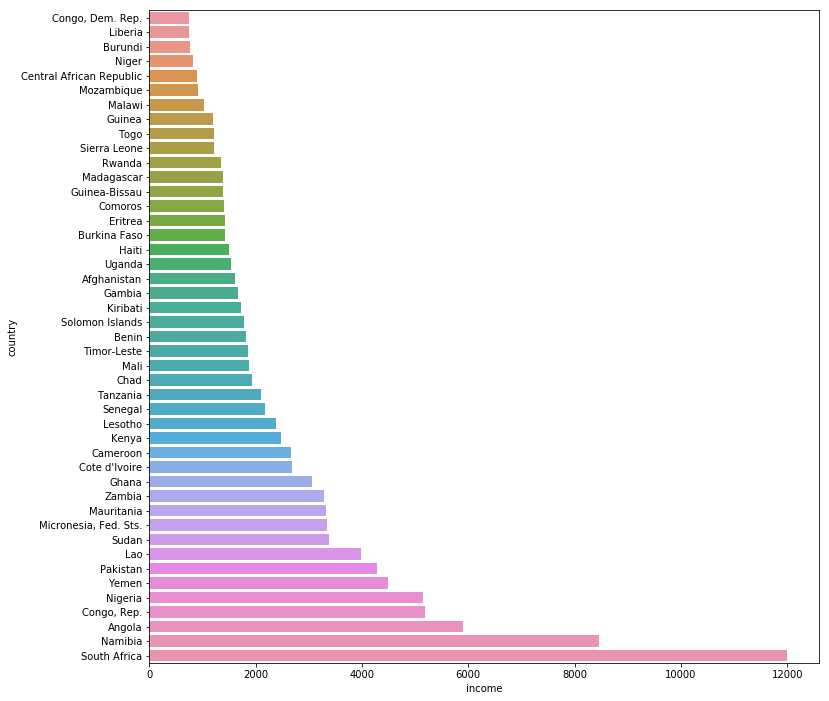

In [65]:
plt.figure(figsize = (12,12))
temp_df = final_data.sort_values(by=["income"], ascending = True)
sns.barplot(x="income", y = temp_df["country"].loc[temp_df["country_type"]=='Needs aid'], data = temp_df)
plt.show()

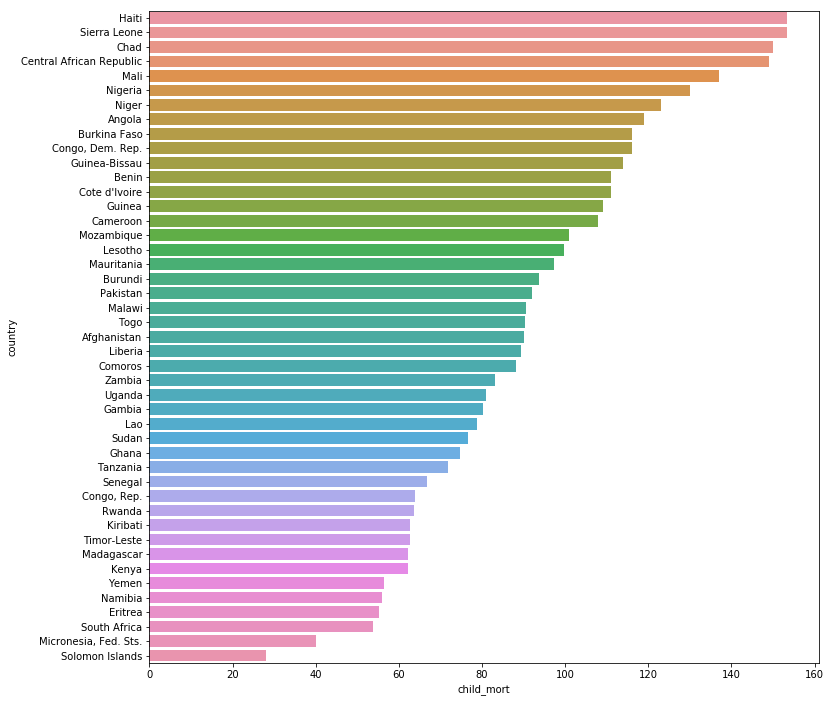

In [66]:
plt.figure(figsize = (12,12))
temp_df = final_data.sort_values(by=["child_mort"], ascending = False)
sns.barplot(x="child_mort", y = temp_df["country"].loc[temp_df["country_type"]=='Needs aid'], data = temp_df)
plt.show()

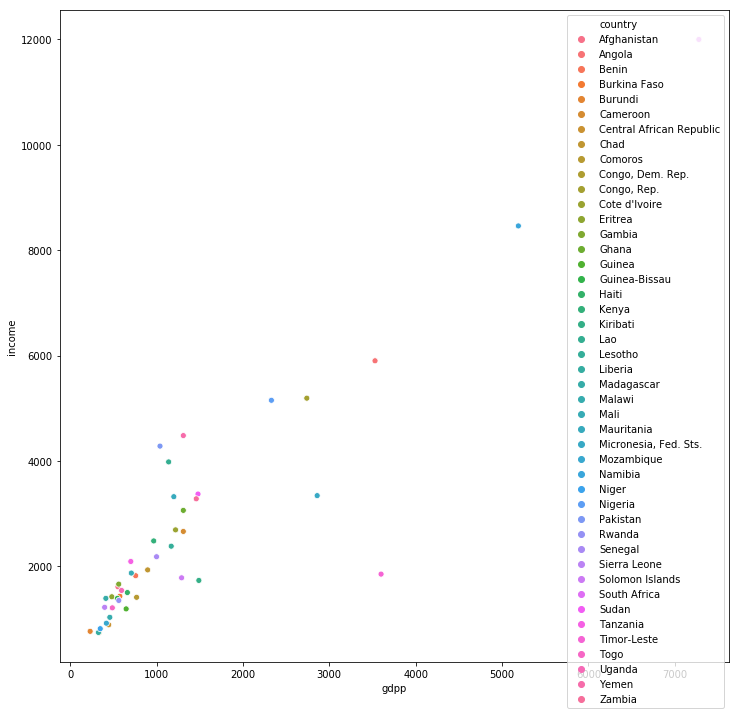

In [67]:
plt.figure(figsize = (12,12))
sns.scatterplot(x="gdpp", y = "income", hue = final_data["country"].loc[final_data["country_type"]=='Needs aid'],
                data = final_data)
plt.show()

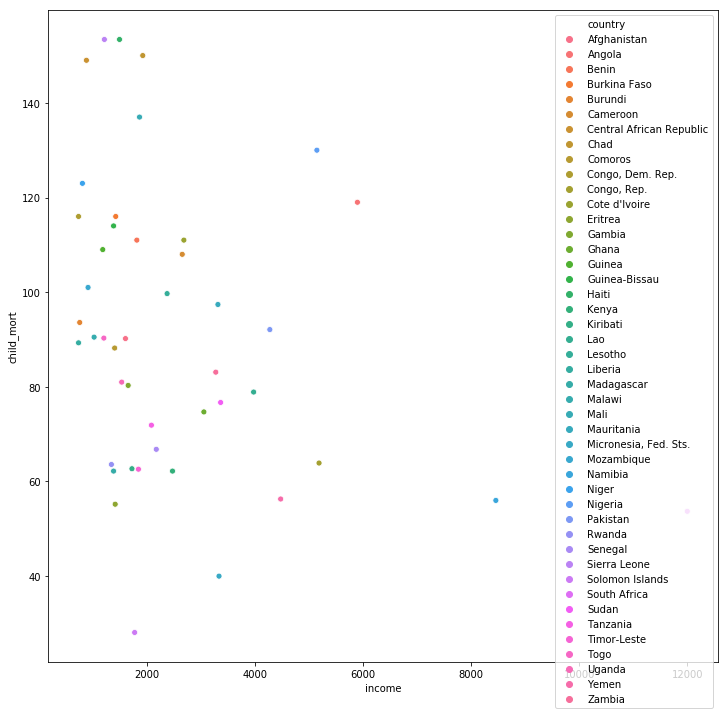

In [68]:
plt.figure(figsize = (12,12))
sns.scatterplot(x="income", y = "child_mort", hue = final_data["country"].loc[final_data["country_type"]=='Needs aid'],
                data = final_data)
plt.show()

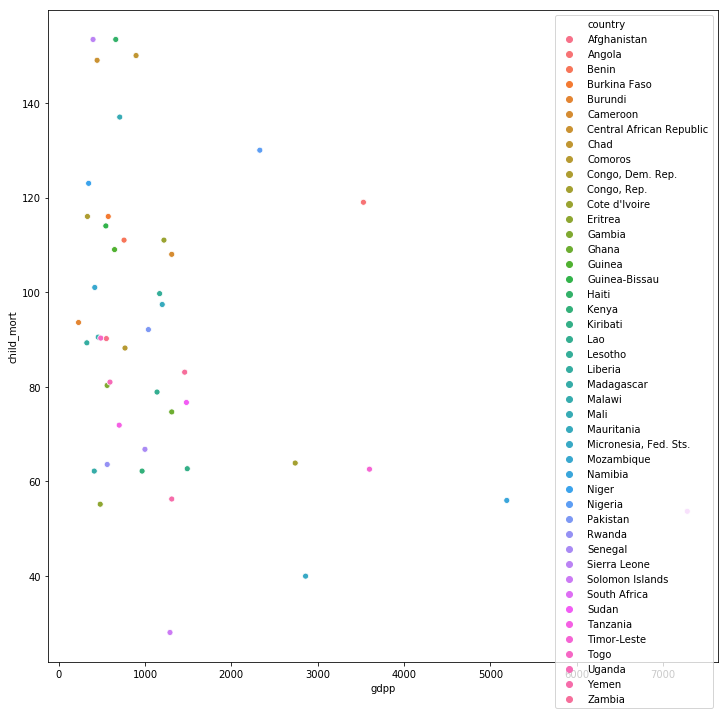

In [69]:
plt.figure(figsize = (12,12))
sns.scatterplot(x="gdpp", y = "child_mort", hue = final_data["country"].loc[final_data["country_type"]=='Needs aid'],
                data = final_data)
plt.show()

Based on the above observations, some of the countries that are in need of aid are:
- Central African Republic
- Sierra Leone
- Haiti
- Chad
- Congo, Dem. Rep.
- Niger
- Mali
- Burundi
- Burkina Faso
- Liberia, and more

In [75]:
#importing file to csv
final_data.to_csv(r'D:\upGrad\.CONTENT\Assignments\Clustering and PCA Assignment\Clustered file.csv', index=False)